# Physics-Informed Neural Networks

## Allan Peter Engsig-Karup (apek@dtu.dk)
## May 7th, 2024

In [ ]:
# How to run
# Use the following commands:
#
# python3 -m venv venv
# ./venv/Scripts/activate
# python3 -m pip install torch matplotlib
#
# Rerun the activate script every time you open your editor again.
# And install whatever VS Code tells you to (usually ipykernel)

We consider in the following the use of Physics-Informed Neural Networks(PINNs) for the construction of a surrogate model for the solution to the linear advection equation in one space dimension.
$u_{t}+cu_{x}=0 \qquad  t ∈ \mathbb{R^+}, x ∈ \mathbb{R}$ 
This problem have analytical solutions in the form $u(x,t)=f(x-ct)$, and an initial condition of the form $u(x,0)=f(x)=\sin(\pi x)$ is assumed. For $c>0$, a boundary condition is imposed on the left boundary because the information is travelling from left to right in this case
$u(0,t)=f(-ct)=\sin(-\pi ct)$

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

def u_real_const() -> Callable[[torch.float64, torch.float64, torch.float64], torch.float64]:
    a = [1.0, 4.0, 16.0]
    b = [0.0, 0.0, 0.0]

    def u_real(eps: torch.float64, x: torch.float64, t: torch.float64) -> torch.float64:
        nonlocal a, b
        def one_layer(eps, a, b, x, t):
            return torch.exp(-eps*a*a*t)*(a*torch.cos(a*x) + b*torch.sin(a*x)) 
        sum = torch.zeros_like(x)
        for (a_, b_) in zip(a, b):
            sum += one_layer(eps, a_, b_, x, t)
        return sum
    return u_real
def u_real_const():
    def u_real(eps: torch.float64, x: torch.float64, t: torch.float64) -> torch.float64:
        y = x - eps*t
        return torch.sin(2*torch.pi*y)
    return u_real

u_real = u_real_const()

# High precision
torch.set_default_dtype(torch.float64)

# Define device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA on GPU")
# Check for MPS availability next if CUDA is not available (for macOS with Apple Silicon)
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS on Apple Silicon GPU")
    torch.set_default_dtype(torch.float32) # mps does not allow for float64
# Default to CPU if neither CUDA nor MPS is available
else:
    device = torch.device("cpu")
    print("Using CPU")

# Define the neural network model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 30),
            nn.ReLU(),
            nn.Linear(30, 30),
            nn.ReLU(),
            nn.Linear(30, 30),
            nn.ReLU(),
            nn.Linear(30, 30),
            nn.ReLU(),
            nn.Linear(30, 30),
            nn.ReLU(),
            nn.Linear(30, 1)
        )

    def forward(self, x, t):
        xt = torch.cat((x, t), dim=1)
        u = self.net(xt)
        return u

# Helper functions to calculate derivatives
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True, retain_graph=True)[0]

# Physics-informed loss
def loss_fn(model, x, t, eps, w_pde, w_boundary, w_initial, to_print=False):
    x.requires_grad_(True)
    t.requires_grad_(True)

    u = model(x, t)

    u_t = grad(u, t)
    u_x = grad(u, x)
    #u_xx = grad(u_x, x)

    # PDE loss
    #f = u_t + c * u_x  # Ensure 'c' is defined or passed to the function
    #f = eps*u_xx - u
    f = u_t + eps*u_x

    # Boundary conditions (ensure these are correct for your problem)
    #boundary_condition1 = model(-1*torch.ones_like(x), t) - u_real(eps, -1*torch.ones_like(x), t)
    #boundary_condition2 = model(torch.ones_like(x), t) - u_real(eps, torch.ones_like(x), t)
    boundary_condition = model(-1*torch.ones_like(x), t) - model(torch.ones_like(x), t)
    initial_condition = model(x, torch.zeros_like(t)) - u_real(eps, x, torch.zeros_like(t))

    # Compute MSE for PDE, boundary, and initial conditions
    loss_pde = torch.mean(f**2)
    #loss_boundary = torch.mean(boundary_condition1**2) + torch.mean(boundary_condition2**2)
    loss_boundary = torch.mean(boundary_condition**2)
    loss_initial = torch.mean(initial_condition**2)

    if to_print:
        print(f"pde: {loss_pde:2f}, boundary: {loss_boundary:2f}, initial: {loss_initial:2f}")

    return w_pde*loss_pde + w_boundary*loss_boundary + w_initial*loss_initial
    
# Training
def train(model, epochs, optimizer, scheduler, x, t, eps, w_pde, w_boundary, w_initial):
    model.train()
    try:
        for epoch in range(epochs):
            to_print = True if epoch % 200 == 0 else False
            optimizer.zero_grad()
            l = loss_fn(model, x, t, eps, w_pde, w_boundary, w_initial, to_print)
            l.backward()
            optimizer.step()
            scheduler.step()
            if epoch % 50 == 0:
                print(f'Epoch {epoch}: Loss = {l.item():2f}, lr = {scheduler.get_last_lr()}')
    except KeyboardInterrupt:
        print(f'Epoch {epoch}: Loss = {l.item():2f}, lr = {scheduler.get_last_lr()}')

In [31]:
# Grid points
xmin, xmax, nx = -1, 1, 100
#tmin, tmax, nt = 0, 0.05, 100
tmin, tmax, nt = 0, 2*torch.pi, 100
x = torch.linspace(xmin, xmax, nx, device=device).unsqueeze(1)
t = torch.linspace(tmin, tmax, nt, device=device).unsqueeze(1)
x_mesh, t_mesh = torch.meshgrid(x.flatten(), t.flatten())
x_mesh, t_mesh = x_mesh.flatten().unsqueeze(1), t_mesh.flatten().unsqueeze(1)

# Constants
eps = 0.5

# Initialize model, optimizer
model = PINN().to(device)
# Change learning rate maybe
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Change step size and gamma maybe
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=1.0)

max_iters = 30000

# Change loss weights maybe
w_pde = 1.0
w_boundary = 10.0
w_initial = 5.0
# Train the model
train(model, max_iters, optimizer, scheduler, x_mesh, t_mesh, eps, w_pde, w_boundary, w_initial)


Using CPU
pde: 0.000008, boundary: 0.000010, initial: 0.494832
Epoch 0: Loss = 2.474267, lr = [0.001]
Epoch 50: Loss = 2.259374, lr = [0.001]
Epoch 100: Loss = 1.141143, lr = [0.001]
Epoch 150: Loss = 0.493499, lr = [0.001]
pde: 0.260325, boundary: 0.000710, initial: 0.014352
Epoch 200: Loss = 0.339186, lr = [0.001]
Epoch 250: Loss = 0.288274, lr = [0.001]
Epoch 300: Loss = 0.252174, lr = [0.001]
Epoch 350: Loss = 0.212718, lr = [0.001]
pde: 0.144598, boundary: 0.000413, initial: 0.006099
Epoch 400: Loss = 0.179226, lr = [0.001]
Epoch 450: Loss = 0.154239, lr = [0.001]
Epoch 500: Loss = 0.133668, lr = [0.001]
Epoch 550: Loss = 0.116627, lr = [0.001]
pde: 0.086488, boundary: 0.000273, initial: 0.002199
Epoch 600: Loss = 0.100211, lr = [0.001]
Epoch 650: Loss = 0.091691, lr = [0.001]
Epoch 700: Loss = 0.085925, lr = [0.001]
Epoch 750: Loss = 0.080182, lr = [0.001]
pde: 0.067476, boundary: 0.000192, initial: 0.001250
Epoch 800: Loss = 0.075652, lr = [0.001]
Epoch 850: Loss = 0.070903, lr 

In [32]:
PATH = "hyperbolic.pt"
torch.save(model.state_dict(), PATH)

In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'model' and 'device' are already defined and the model is trained.
device = torch.device("cpu")
model = PINN()
model.load_state_dict(torch.load(PATH))

# Generate predictions from the trained model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    u_pred = model(x_mesh, t_mesh).cpu().numpy()

# Exact solution (update this according to your problem's exact solution)
u_exact = u_real(eps, x_mesh, t_mesh).cpu().detach().numpy()

#u_exact = np.sin( np.pi * (x_mesh.cpu().detach().numpy() - c*t_mesh.cpu().detach().numpy()))
                 
# Compute L2 errors
l2_err = np.sum((u_exact - u_pred)**2)
l2_err_t0 = np.sum((u_exact[0, :] - u_pred[0, :])**2)
l2_err_tmax = np.sum((u_exact[-1, :] - u_pred[-1, :])**2)

# Output error information
print(f'L2 err, all timesteps: {l2_err}')
print(f'Avg-L2 err, all timesteps: {l2_err/u_pred.size}')
print(f'L2 err, t=0: {l2_err_t0}')
print(f'L2 err, t={tmax}: {l2_err_tmax}')


L2 err, all timesteps: 339.7060696354222
Avg-L2 err, all timesteps: 0.03397060696354222
L2 err, t=0: 2.101514482371175e-07
L2 err, t=6.283185307179586: 0.18346424446529894


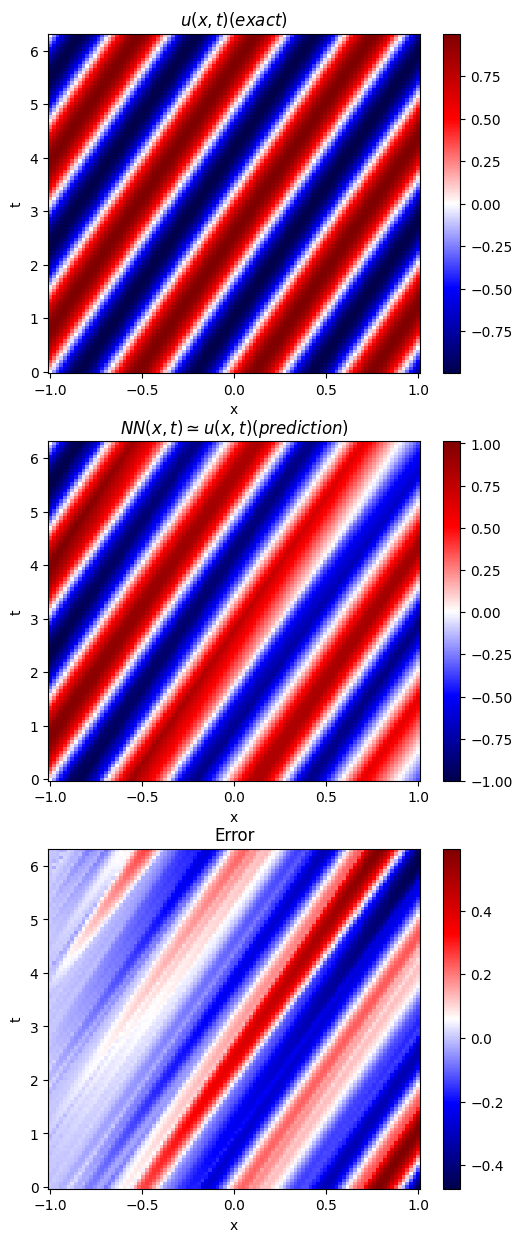

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your x_mesh and t_mesh are defined correctly in the tensor form.
x = torch.linspace(xmin, xmax, nx, device=device).cpu().numpy()
t = torch.linspace(tmin, tmax, nt, device=device).cpu().numpy()

# Since these are grid centers, calculate the step size and expand the grid to cover edges.
x_step = (x[1] - x[0])
t_step = (t[1] - t[0])

# Create new arrays that represent the edges, not the centers
x_edges = np.append(x, x[-1] + x_step) - x_step/2
t_edges = np.append(t, t[-1] + t_step) - t_step/2

# Use these arrays for pcolormesh
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 15))

# Exact solution
ax = axes[0]
cc = ax.pcolormesh(x_edges, t_edges, u_exact.reshape((nt, nx)), cmap='seismic', shading='auto')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('$u(x,t) (exact)$')
fig.colorbar(cc, ax=ax)

# Predicted solution
ax = axes[1]
cc = ax.pcolormesh(x_edges, t_edges, u_pred.reshape((nt, nx)), cmap='seismic', shading='auto')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('$NN(x,t)\simeq u(x,t) (prediction)$')
fig.colorbar(cc, ax=ax)

# Errors
ax = axes[2]
cc = ax.pcolormesh(x_edges, t_edges, u_exact.reshape((nt, nx)) - u_pred.reshape((nt, nx)), cmap='seismic', shading='auto')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Error')
fig.colorbar(cc, ax=ax)
